In [1]:
import numpy as np
from scipy import stats
import math
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import sys
from haversine import haversine
import pandas as pd
import geopandas as gpd

In [3]:
def custom_dist(u, v):
    if u[2] == v[2]:
        return sys.float_info.max
    else:
        return haversine([u[0], u[1]], [v[0], v[1]])

thresholds = {'CurbRamp': 0.0075,
                      'NoCurbRamp': 0.0075,
                      'SurfaceProblem': 0.01,
                      'Obstacle': 0.01,
                      'NoSidewalk': 0.01,
                      'Crosswalk': 0.01,
                      'Signal': 0.01,
                      'Occlusion': 0.01,
                      'Other': 0.01,
                      'Problem': 0.01}

def cluster(labels, label_type, thresholds):

    # Makes a normal dist matrix for a single user, but uses special dist function for multi-user clustering that
    # prevents the same user's attributes from being clustered together.
    dist_matrix = pdist(np.array(labels[['lat', 'lng', 'user_id']].values), custom_dist)
    link = linkage(dist_matrix, method='complete')
    curr_type = labels['label_type'].values

    # Copies the labels dataframe and adds a column to it for the cluster id each label is in.
    labelsCopy = labels.copy()
    labelsCopy.loc[:,'cluster_id'] = fcluster(link, t=thresholds[label_type], criterion='distance')

    # Cuts tree so that only labels less than clust_threth kilometers apart are clustered.
    clusters = labelsCopy.groupby('cluster_id')

    # Computes the center of each cluster and assigns temporariness and severity.
    cluster_list = [] # list of tuples (label_type, cluster_num, lat, lng, severity, temporary).
    for clust_num, clust in clusters:
        #ave_pos = np.mean(clust['coords'].tolist(), axis=0) # use ave pos of clusters.
        #ave_sev = None if pd.isnull(clust['severity']).all() else int(round(np.median(clust['severity'][~np.isnan(clust['severity'])])))
        #ave_temp = None if pd.isnull(clust['temporary']).all() else bool(round(np.mean(clust['temporary'])))

        cluster_list.append((curr_type, clust_num))

    cluster_df = pd.DataFrame(cluster_list, columns=['label_type', 'cluster_id'])

    return (cluster_df, labelsCopy)


# Pick which label types should be included in clustering, and which should be included in the "Problem" type.
label_types = ['CurbRamp', 'NoSidewalk', 'Occlusion', 'SurfaceProblem', 'Obstacle', 'Other', 'NoCurbRamp', 'Crosswalk', 'Signal']
# problem_types = ['SurfaceProblem', 'Obstacle']

# These are the columns required in the POST requests for the labels and clusters, respectively.
label_cols = ['label_id', 'label_type', 'cluster_id']
cluster_cols = ['label_type', 'cluster_id', 'lat', 'lng', 'severity', 'temporary']


def cluster_label_type_at_index(label_data,i):
        clusters_for_type_i = pd.DataFrame(columns=cluster_cols)
        labels_for_type_i = pd.DataFrame(columns=label_cols)

        label_type = label_types[i]
        # if label_type == 'Problem':
        #     type_data = label_data[label_data.label_type.isin(problem_types)]
        # else:
        type_data = label_data[label_data.label_type == label_type]

        # If there are >1 labels, we can do clustering. Otherwise just copy the 1 (or 0) labels.
        if type_data.shape[0] > 1:
            (clusters_for_type_i, labels_for_type_i) = cluster(type_data, label_type, thresholds)
        elif type_data.shape[0] == 1:
            labels_for_type_i = type_data.copy()
            labels_for_type_i.loc[:,'cluster_id'] = 1 # Gives the single cluster a cluster_id of 1.
            labels_for_type_i.loc[:,'label_type'] = label_type # Gives Problem type if needed.
            clusters_for_type_i = labels_for_type_i.filter(items=cluster_cols)

        return (label_type, clusters_for_type_i, labels_for_type_i)

In [4]:
df = gpd.read_file('data/processed-labels/labels_all_chicago/labels_all_chicago.shp')

In [5]:
df

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry
0,3,8,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,2.0,None,1,pMph48Z6Xz2hexFJ7q3d_Q,2,136.687500,-18.625000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083668,-87.980347,POINT (-87.98035 42.08367)
1,3,9,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,1.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,2,249.937500,-14.125000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083694,-87.980606,POINT (-87.98061 42.08369)
2,3,10,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,2.0,0,1,pMph48Z6Xz2hexFJ7q3d_Q,3,288.656250,-13.187500,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083786,-87.980606,POINT (-87.98061 42.08379)
3,3,11,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,3.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,3,49.245537,-16.220982,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083794,-87.980354,POINT (-87.98035 42.08379)
4,3,12,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,3.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,3,42.636162,-16.033482,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083817,-87.980362,POINT (-87.98036 42.08382)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,4588,21507,hhAF_qDTHgN0dL8SNsr-oA,SurfaceProblem,3.0,1,1,hhAF_qDTHgN0dL8SNsr-oA,1,126.341515,-32.937500,179.073898,0.395355,71959a82-3f47-4dec-a02b-86669bf8095b,41.611179,-87.664291,POINT (-87.66429 41.61118)
18281,4588,21508,hhAF_qDTHgN0dL8SNsr-oA,SurfaceProblem,2.0,None,1,hhAF_qDTHgN0dL8SNsr-oA,1,213.154022,-35.000000,179.073898,0.395355,71959a82-3f47-4dec-a02b-86669bf8095b,41.611137,-87.664551,POINT (-87.66455 41.61114)
18282,4589,21509,tZWhmOw4CIP9bQLJycSyqQ,CurbRamp,1.0,None,1,tZWhmOw4CIP9bQLJycSyqQ,3,217.380630,-16.302500,179.386520,-0.660645,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,41.609871,-87.646339,POINT (-87.64634 41.60987)
18283,4601,21517,nWTcoxo4S0MImzzvlQGwpQ,CurbRamp,1.0,1,1,nWTcoxo4S0MImzzvlQGwpQ,3,248.244995,-13.510625,359.491150,-0.079690,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,41.625626,-87.651291,POINT (-87.65129 41.62563)


In [6]:
df0 = cluster_label_type_at_index(df,0)[2]

In [7]:
df1 = cluster_label_type_at_index(df,1)[2]

In [8]:
df2 = cluster_label_type_at_index(df,2)[2]

In [9]:
df3 = cluster_label_type_at_index(df,3)[2]

In [10]:
df4 = cluster_label_type_at_index(df,4)[2]

In [11]:
df5 = cluster_label_type_at_index(df,5)[2]

In [12]:
df6 = cluster_label_type_at_index(df,6)[2]

In [13]:
df7 = cluster_label_type_at_index(df,7)[2]

In [14]:
df8 = cluster_label_type_at_index(df,8)[2]

In [15]:
df0["clustered"] = df0.duplicated(subset="cluster_id", keep=False)
df1["clustered"] = df1.duplicated(subset="cluster_id", keep=False)
df2["clustered"] = df2.duplicated(subset="cluster_id", keep=False)
df3["clustered"] = df3.duplicated(subset="cluster_id", keep=False)
df4["clustered"] = df4.duplicated(subset="cluster_id", keep=False)
df5["clustered"] = df5.duplicated(subset="cluster_id", keep=False)
df6["clustered"] = df6.duplicated(subset="cluster_id", keep=False)
df7["clustered"] = df7.duplicated(subset="cluster_id", keep=False)
df8["clustered"] = df8.duplicated(subset="cluster_id", keep=False)

In [16]:
df0

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,cluster_id,clustered
0,3,8,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,2.0,None,1,pMph48Z6Xz2hexFJ7q3d_Q,2,136.687500,-18.625000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083668,-87.980347,POINT (-87.98035 42.08367),4248,False
1,3,9,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,1.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,2,249.937500,-14.125000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083694,-87.980606,POINT (-87.98061 42.08369),2476,False
2,3,10,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,2.0,0,1,pMph48Z6Xz2hexFJ7q3d_Q,3,288.656250,-13.187500,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083786,-87.980606,POINT (-87.98061 42.08379),4315,False
3,3,11,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,3.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,3,49.245537,-16.220982,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083794,-87.980354,POINT (-87.98035 42.08379),2414,False
4,3,12,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,3.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,3,42.636162,-16.033482,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083817,-87.980362,POINT (-87.98036 42.08382),4730,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,4588,21499,htYgFrypIVbNnNTSpoHjxQ,CurbRamp,2.0,None,1,htYgFrypIVbNnNTSpoHjxQ,1,207.904022,-34.812500,179.118057,0.400970,71959a82-3f47-4dec-a02b-86669bf8095b,41.611633,-87.664497,POINT (-87.66450 41.61163),41,False
18274,4588,21501,htYgFrypIVbNnNTSpoHjxQ,CurbRamp,4.0,None,1,htYgFrypIVbNnNTSpoHjxQ,1,227.216522,-35.000000,179.118057,0.400970,71959a82-3f47-4dec-a02b-86669bf8095b,41.611679,-87.664543,POINT (-87.66454 41.61168),36,False
18282,4589,21509,tZWhmOw4CIP9bQLJycSyqQ,CurbRamp,1.0,None,1,tZWhmOw4CIP9bQLJycSyqQ,3,217.380630,-16.302500,179.386520,-0.660645,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,41.609871,-87.646339,POINT (-87.64634 41.60987),29,True
18283,4601,21517,nWTcoxo4S0MImzzvlQGwpQ,CurbRamp,1.0,1,1,nWTcoxo4S0MImzzvlQGwpQ,3,248.244995,-13.510625,359.491150,-0.079690,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,41.625626,-87.651291,POINT (-87.65129 41.62563),18,True


In [17]:
#concatenate all dataframes
clusters = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8])

In [18]:
clusters

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,cluster_id,clustered
0,3,8,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,2.0,None,1,pMph48Z6Xz2hexFJ7q3d_Q,2,136.687500,-18.625000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083668,-87.980347,POINT (-87.98035 42.08367),4248,False
1,3,9,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,1.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,2,249.937500,-14.125000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083694,-87.980606,POINT (-87.98061 42.08369),2476,False
2,3,10,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,2.0,0,1,pMph48Z6Xz2hexFJ7q3d_Q,3,288.656250,-13.187500,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083786,-87.980606,POINT (-87.98061 42.08379),4315,False
3,3,11,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,3.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,3,49.245537,-16.220982,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083794,-87.980354,POINT (-87.98035 42.08379),2414,False
4,3,12,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,3.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,3,42.636162,-16.033482,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083817,-87.980362,POINT (-87.98036 42.08382),4730,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17449,4462,20591,7zsiM839-xDgso5xZohzxQ,Signal,NaN,1,1,7zsiM839-xDgso5xZohzxQ,1,4.000000,-10.000000,179.707504,-0.300110,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.618954,-87.641510,POINT (-87.64151 41.61895),6,False
17450,4462,20592,7zsiM839-xDgso5xZohzxQ,Signal,NaN,1,1,7zsiM839-xDgso5xZohzxQ,3,60.359375,-6.625000,179.707504,-0.300110,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.618923,-87.641174,POINT (-87.64117 41.61892),37,False
17836,4510,21002,Jra46TqXcZtPHeY_4j25-A,Signal,NaN,1,1,Jra46TqXcZtPHeY_4j25-A,3,65.997765,0.000000,167.151917,-0.512085,325198df-cddc-44ee-a87e-c831c3147aa0,41.610004,-87.670891,POINT (-87.67089 41.61000),30,False
17837,4511,21003,Vc4N3DE4Pc7aEmzZckn4-A,Signal,NaN,1,1,Vc4N3DE4Pc7aEmzZckn4-A,3,65.997765,0.000000,166.867004,0.293160,325198df-cddc-44ee-a87e-c831c3147aa0,41.609806,-87.670830,POINT (-87.67083 41.60981),20,False


<AxesSubplot: >

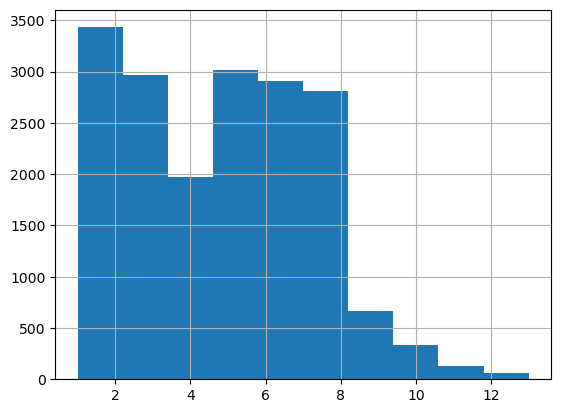

In [19]:
#count the number of same cluser_ids and store in a column
clusters['count'] = clusters.groupby('cluster_id')['cluster_id'].transform('count')
#count in histogram
clusters['count'].hist()

In [20]:
#select only label_id cluster_id and count
clusters = clusters[['label_id', 'cluster_id', 'count']]
clusters

,label_id,cluster_id,count
0,8,4248,1
1,9,2476,2
2,10,4315,1
3,11,2414,2
4,12,4730,1
...,...,...,...
17449,20591,6,10
17450,20592,37,10
17836,21002,30,10
17837,21003,20,10


In [22]:
#make new folder features
!mkdir data/features

In [23]:
#export to shapefile
clusters.to_csv('data/features/clustered.csv', index=False)